In [184]:
import os
import pandas as pd
from wildlife_datasets import datasets
from wildlife_datasets.analysis import display_statistics
from wildlife_datasets import splits
import torchvision.transforms as T
import timm
from wildlife_tools.features import *
from wildlife_tools.data import ImageDataset
from wildlife_tools.similarity import CosineSimilarity, MatchLOFTR, MatchLightGlue
from wildlife_tools.similarity.wildfusion import SimilarityPipeline, WildFusion
from wildlife_tools.similarity.calibration import IsotonicCalibration
import numpy as np
from wildlife_tools.inference import KnnClassifier
import matplotlib.pyplot as plt
from PIL import Image  
import pickle
import yaml

In [185]:
# --- Load Configuration ---
with open('config.yml', 'r') as f:
    config = yaml.safe_load(f)

In [186]:
data_root = os.path.expanduser(config['paths']['data_root'])
image_dir = config['paths']['dataset_dir'].format(data_root=data_root)
manifest_file = config['paths']['merged_manifest_file'].format(data_root=data_root)
features_dir = config['paths']['features_dir'].format(data_root=data_root)

In [187]:
class Horses(datasets.WildlifeDataset):
    def __init__(self, root_dir, manifest_file_path):
        self.manifest_file_path = manifest_file_path
        super().__init__(root_dir)

    def create_catalogue(self) -> pd.DataFrame:
        """Create catalogue from manifest file"""
        manifest_df = pd.read_csv(self.manifest_file_path)
        
        rows = []
        for _, row in manifest_df.iterrows():
            if 'status' in row and row['status'] == 'EXCLUDE':
                continue
            if 'num_horses_detected' in row and row['num_horses_detected'] in ['NONE', 'MULTIPLE']:
                continue

            # Parse segmentation mask from "x1 y1;x2 y2;..." format
            segmentation_data = None
            mask_str = row.get('segmentation_mask')
            if mask_str and pd.notna(mask_str) and isinstance(mask_str, str) and mask_str.strip():
                try:
                    # Parse the "x1 y1;x2 y2;..." format into a flat list [x1, y1, x2, y2, ...]
                    points = []
                    for point_str in mask_str.split(';'):
                        if ' ' in point_str:
                            x_str, y_str = point_str.strip().split()
                            points.extend([float(x_str), float(y_str)])
                    
                    if len(points) >= 6:  # At least 3 points for a valid polygon
                        segmentation_data = points  # Flat list format
                except (ValueError, IndexError) as e:
                    print(f"Warning: Failed to parse segmentation for {row['filename']}: {e}")
                    pass

            # Parse bbox data - now in pixel coordinates from detector
            bbox_data = None
            if all(col in row and pd.notna(row[col]) for col in ['bbox_x', 'bbox_y', 'bbox_width', 'bbox_height']):
                try:
                    # Bbox coordinates are already in pixel format from the detector
                    bbox_data = [
                        int(row['bbox_x']),
                        int(row['bbox_y']), 
                        int(row['bbox_width']),
                        int(row['bbox_height'])
                    ]
                except (ValueError, TypeError) as e:
                    print(f"Warning: Failed to parse bbox for {row['filename']}: {e}")
                    pass

            rows.append({
                'image_id': row['filename'],
                'identity': row['canonical_id'],
                'horse_name': row['horse_name'],
                'path': row['filename'],
                'date': pd.to_datetime(str(row['email_date']), format='%Y%m%d'),
                'segmentation': segmentation_data,
                'bbox': bbox_data,
            })
        
        # Create DataFrame from collected rows
        df = pd.DataFrame(rows)
        result = self.finalize_catalogue(df)
        return result

In [188]:
horses = Horses(image_dir,manifest_file_path=manifest_file)
horses_df = horses.create_catalogue()

Figure(640x480)


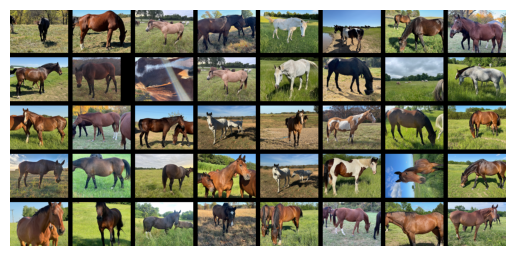

In [189]:
print(horses.plot_grid())

Number of identitites            196
Number of all animals            2177
Number of animals with one image 5
Number of unidentified animals   0
Images span                      2.6 years


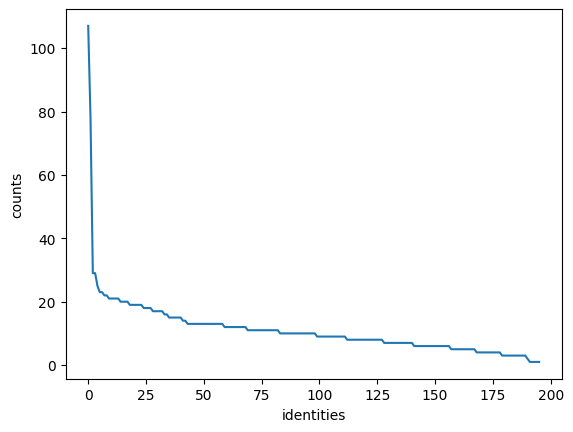

In [190]:
display_statistics(horses_df)

filter to include only those identities with > 20 images

In [191]:
horses_df = horses_df.groupby('identity').filter(lambda x: len(x) > 20)

Number of identitites            14
Number of all animals            463
Number of animals with one image 0
Number of unidentified animals   0
Images span                      1.5 years


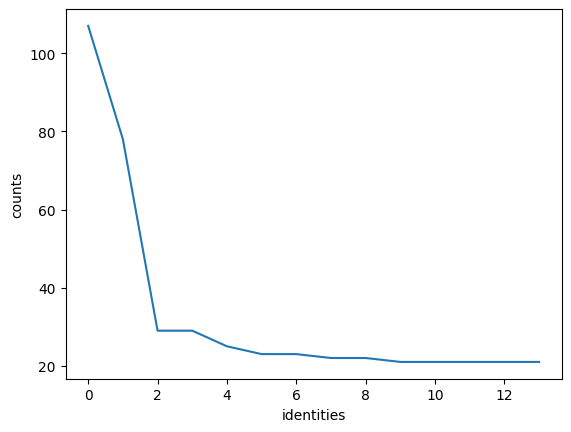

In [192]:
display_statistics(horses_df)

Using row 79 for visual comparison


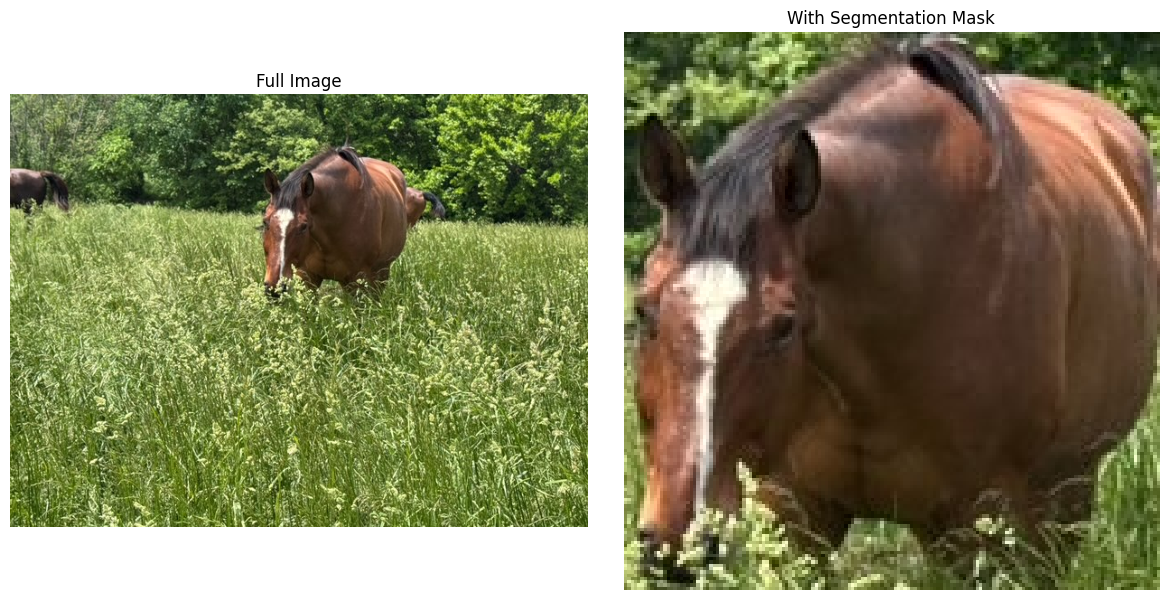

Image shapes - Full: (480, 640, 3), Masked: (170, 163, 3)


In [193]:
# Visual comparison: with and without segmentation
if horses_df['segmentation'].notna().any():
    # Find a row with segmentation data
    seg_indices = horses_df[horses_df['segmentation'].notna()].index
    if len(seg_indices) > 0:
        seg_row_idx = seg_indices[0]
        print(f"Using row {seg_row_idx} for visual comparison")
        
        # Create two datasets: one with full image, one with mask
        test_df = horses_df.loc[[seg_row_idx]]
        
        # Full image dataset
        horses_full = Horses(image_dir, manifest_file_path=manifest_file)
        horses_full.df = test_df
        horses_full.transform = None  # No transform for visualization
        horses_full.img_load = "full"
        horses_full.load_label = False
        
        # Masked image dataset  
        horses_masked = Horses(image_dir, manifest_file_path=manifest_file)
        horses_masked.df = test_df
        horses_masked.transform = None  # No transform for visualization
        horses_masked.img_load = "bbox"
        horses_masked.load_label = False
        
        try:
            # Get the images
            img_full = horses_full[0]
            img_masked = horses_masked[0]
            
            # Display side by side
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
            
            ax1.imshow(img_full)
            ax1.set_title("Full Image")
            ax1.axis('off')
            
            ax2.imshow(img_masked)
            ax2.set_title("With Segmentation Mask")
            ax2.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print(f"Image shapes - Full: {np.array(img_full).shape}, Masked: {np.array(img_masked).shape}")
        except Exception as e:
            print(f"Error loading images for comparison: {e}")
    else:
        print("No valid segmentation indices found")
else:
    print("No segmentation data found - cannot create visual comparison")

In [194]:
# Debug: Check bbox data
print("Checking bbox data:")
print(f"Bbox column exists: {'bbox' in horses_df.columns}")
if 'bbox' in horses_df.columns:
    print(f"Rows with bbox data: {horses_df['bbox'].notna().sum()}")
    print(f"Sample bbox values:")
    for i, bbox in enumerate(horses_df['bbox'].head(5)):
        print(f"  Row {i}: {bbox}")

# Check raw manifest bbox columns
manifest_df = pd.read_csv(manifest_file)
bbox_cols = ['bbox_x', 'bbox_y', 'bbox_width', 'bbox_height']
print(f"\nRaw manifest bbox columns exist: {[col for col in bbox_cols if col in manifest_df.columns]}")
if all(col in manifest_df.columns for col in bbox_cols):
    print("Sample raw bbox data:")
    sample_rows = manifest_df[manifest_df['num_horses_detected'] == 'SINGLE'].head(3)
    for i, (idx, row) in enumerate(sample_rows.iterrows()):
        print(f"  Row {i}: x={row['bbox_x']}, y={row['bbox_y']}, w={row['bbox_width']}, h={row['bbox_height']}")
else:
    print("Missing some bbox columns in manifest")

Checking bbox data:
Bbox column exists: True
Rows with bbox data: 463
Sample bbox values:
  Row 0: [277, 58, 163, 170]
  Row 1: [181, 0, 308, 322]
  Row 2: [236, 8, 309, 363]
  Row 3: [174, 0, 463, 411]
  Row 4: [0, 0, 632, 398]

Raw manifest bbox columns exist: ['bbox_x', 'bbox_y', 'bbox_width', 'bbox_height']
Sample raw bbox data:
  Row 0: x=162.0, y=0.0, w=1567.0, h=1354.0
  Row 1: x=1360.0, y=913.0, w=693.0, h=528.0
  Row 2: x=1166.0, y=771.0, w=292.0, h=213.0


# Testing

Split the features into *query* and *database* sets

In [195]:
splitter = splits.ClosedSetSplit(0.8)
for idx_query, idx_database in splitter.split(horses_df):
    splits.analyze_split(horses_df, idx_query, idx_database)
    
df_query = horses_df.loc[idx_query]
df_database = horses_df.loc[idx_database]

transform = T.Compose([T.Resize([384, 384]), T.ToTensor()])


Split: time-unaware closed-set
Samples: train/test/unassigned/total = 371/92/0/463
Classes: train/test/unassigned/total = 14/14/0/14
Samples: train only/test only        = 0/0
Classes: train only/test only/joint  = 0/0/14

Fraction of train set     = 80.13%
Fraction of test set only = 0.00%


## Extract features (with segmentation masks applied)

In [196]:
def test(horses, df_query, df_database, mask):

    print("Testing with mask: ", mask)
    # Create segmentation-enabled datasets using WildlifeDataset directly
    horses_query = Horses(image_dir, manifest_file_path=manifest_file)
    horses_query.df = df_query  # Set the filtered dataframe
    horses_query.transform = transform
    horses_query.img_load = "full" # No mask on query images
    horses_query.load_label = True
    dataset_query = horses_query

    horses_database = Horses(image_dir, manifest_file_path=manifest_file)
    horses_database.df = df_database  # Set the filtered dataframe
    horses_database.transform = transform
    horses_database.img_load = mask  # Apply segmentation mask
    horses_database.load_label = True
    dataset_database = horses_database

    extractor = DeepFeatures(timm.create_model('hf-hub:BVRA/wildlife-mega-L-384', pretrained=True), num_workers=0)
    query, database = extractor(dataset_query), extractor(dataset_database)
    
    # Calculate similarity
    similarity_function = CosineSimilarity()
    similarity = similarity_function(query, database)
    
    # Evaluate
    classifier = KnnClassifier(k=1, database_labels=dataset_database.labels_string)
    predictions = classifier(similarity)
    accuracy = np.mean(dataset_query.labels_string == predictions)
    
    print("accuracy: %s" % accuracy)

In [197]:
test(horses, df_query, df_database, "bbox")

Testing with mask:  bbox


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 30.00s/it]

accuracy: 0.7169811320754716


In [198]:
test(horses, df_query, df_database, "full")

Testing with mask:  full


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.91s/it]

accuracy: 0.7358490566037735


In [199]:
test(horses, df_query, df_database, "full_mask")

Testing with mask:  full_mask


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.73s/it]

accuracy: 0.42587601078167114


In [200]:
test(horses, df_query, df_database, "bbox_mask")

Testing with mask:  bbox_mask


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.86s/it]

accuracy: 0.37735849056603776
